<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h3><center>Andrey Shestakov (<a href="mailto:avshestakov@hse.ru">avshestakov@hse.ru</a>)</center></h3>
<hr>
<h2><center>Boosting.<sup><a href="#fn1" id="ref1">1</a></sup></center></h2>



<sup id="fn1">1. Some materials are taken from <a href="http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%92.%D0%92.%D0%9A%D0%B8%D1%82%D0%BE%D0%B2%29">machine learning course of Victor Kitov</a></sup>

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import subprocess

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

from ipywidgets import interact, IntSlider, fixed, FloatSlider
    
import warnings
warnings.filterwarnings('ignore')

# Let's recall previous lecture

## Ensembles

* Random Forests, Bagging
* Stacking, Blending

# Boosting

## Linear ensembles

$$
F(x)=f_{0}(x)+\alpha_{1}h_{1}(x)+...+\alpha_{M}h_{M}(x)
$$

**Regression:** $\widehat{y}(x)=F(x)$

**Binary classification:** $score(y|x)=F(x),\,\widehat{y}(x)= sign(F(x))$
* Notation: $h_{1}(x),...h_{M}(x)$ are called *base learners, weak learners, base models*.
* Too expensive to optimize $f_{0}(x),h_{1}(x),...h_{M}(x)$ and $\alpha_{1},...\alpha_{M}$ jointly for large $M$.
* May lead to overfitting
* Idea: optimize $f_{0}(x)$ and then each pair $(h_{m}(x),\,\alpha_{m})$ greedily.


## Forward stagewise additive modeling (FSAM)

**Input**: 
* training dataset $(x_{i},y_{i}),\,i=1,2,...N$; 
* loss function $\mathcal{L}(f,y)$,
* general form of "base learner" $h(x|\gamma)$ (dependent from parameter $\gamma$) 
* number $M$ of successive additive approximations.

**ALGORITHM**:
1. Fit initial approximation $f_{0}(x)=\arg\min_{f}\sum_{i=1}^{N}\mathcal{L}(f(x_{i}),y_{i})$ 
2. For $m=1,2,...M$:

    1. find next best classifier
$$
(\alpha_{m},h_{m})=\arg\min_{h,c}\sum_{i=1}^{N}\mathcal{L}(f_{m-1}(x_{i})+\alpha h(x_{i}),\,y_{i})
$$
    2. set
$$
f_{m}(x)=f_{m-1}(x)+\alpha_{m}h_{m}(x)
$$
**Output**: approximation function $f_{M}(x)=f_{0}(x)+\sum_{m=1}^{M}\alpha_{m}h_{m}(x)$

## Comments on FSAM

* Number of steps $M$ should be determined by performance on validation set.
* Step 1 need not be solved accurately, since its mistakes are expected to be corrected by future base learners.
    * we can take $f_{0}(x)=\arg\min_{\beta\in\mathbb{R}}\sum_{i=1}^{N}\mathcal{L}(\beta,y_{i})$ or simply $f_{0}(x)\equiv0$.
* By similar reasoning there is no need to solve 2.A accurately
    * typically very simple base learners are used such as trees of depth=1,2,3.
* For some loss functions, such as $\mathcal{L}(y,f(x))=e^{-yf(x)}$ we can solve FSAM explicitly.
* For general loss functions gradient boosting scheme should be used.

# AdaBoost

## Adaboost (discrete version): assumptions

* binary classification task $y\in\{+1,-1\}$
* family of base classifiers $h(x)=h(x|\gamma)$ where $\gamma$ is some fixed parametrization.
* $h(x)\in\{+1,-1\}$
* classification is performed with $\widehat{y}=sign\{f_{0}(x)+\alpha_{1}f_{1}(x)+...+\alpha_{M}f_{M}(x)\}$
* optimized loss is $\mathcal{L}(y,f(x))=e^{-yf(x)}$
* FSAM is applied

## Exponential loss

<center><img src='img/exp-loss.png' width=900></center>

<center><img src='img/adaboost.png' width=1200></center>

## Adaboost (discrete version): algorithm

**Input**: training dataset $(x_{i},y_{i}),\,i=1,2,...n$; number of additive weak classifiers $M$, a family of weak classifiers $h(x)\in\{+1,-1\}$, trainable on weighted datasets.

**ALGORITHM**:
1. Initialize observation weights $w_{i}=1/n$, $i=1,2,...n$.
2. for $m=1,2,...M$:

    1. fit $h^{m}(x)$ to training data using weights $w_{i}$
    2. compute weighted misclassification rate:
$$
E_{m}=\sum_{i=1}^{N}w_{i}\mathbb{I}[h^{m}(x_i)\ne y_{i}]
$$
    4. compute $\alpha_{m}=\frac{1}{2}\ln\left((1-E_{m})/E_{m}\right)$
    5. update sample weights:
$$
w_{i}\leftarrow \frac{w_{i}e^{-\alpha_{m}y_i h^{m}(x_i)}}{W},$$
Where $W$ is normalization factor $\left(W = \sum_i w_i e^{-\alpha_m y_i h^m(x_i)}\right)$


**Output**: composite classifier $f(x)=sign\left(\sum_{m=1}^{M}\alpha_{m}h^{m}(x)\right)$

In [3]:
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=3, random_state=None)

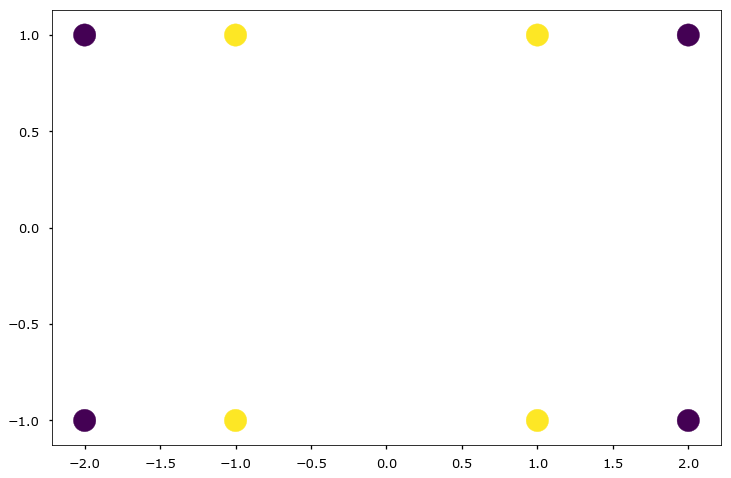

In [4]:
X = np.array([[-2, -1], [-2, 1], [2, -1], [2, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]])
y = np.array([-1,-1,-1,-1,1,1,1,1]) 

plt.scatter(X[:, 0], X[:, 1], c=y, s=500)

In [5]:
def plot_decision(model, rows=1, columns=3):
    fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(15,4))
    ax = ax.ravel()

    xx1, xx2 = np.meshgrid(np.arange(X[:,0].min()-1, X[:,0].max()+1, 0.1),
                           np.arange(X[:,1].min()-1, X[:,1].max()+1, 0.1))

    yy = model.staged_predict(np.c_[xx1.ravel(), xx2.ravel()])

    for i, y_hat in enumerate(yy):
        y_hat = y_hat.reshape(xx1.shape)

        ax[i].set_title('iteration %d' % (i+1))
        ax[i].contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
        ax[i].scatter(X[:, 0], X[:, 1], c=y, s=300)


array([1.09861229, 1.60943791, 1.38629436])

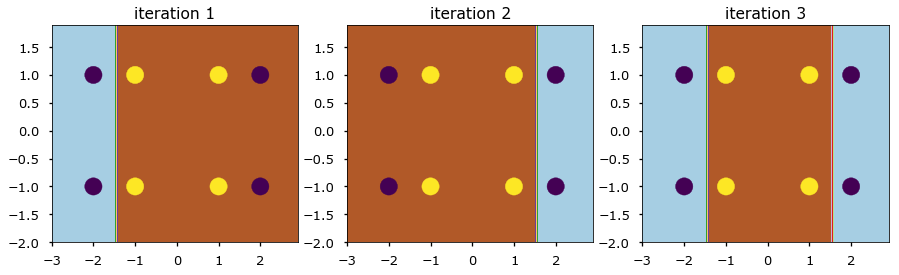

In [6]:
ada = AdaBoostClassifier(n_estimators=3, algorithm='SAMME', 
                         base_estimator=DecisionTreeClassifier(max_depth=1))
ada.fit(X, y)

plot_decision(ada)
ada.estimator_weights_

In [20]:
from sklearn.datasets import make_moons
def ada_demo(n_est=1):

    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,), n_estimators=n_est, learning_rate=0.1)
    ada.fit(X, y)
    

    plt.figure(figsize=(7,5))

    xx1, xx2 = np.meshgrid(np.arange(-1.5, 2.5, 0.1),
                           np.arange(-1, 1.5, 0.1))

    y_hat = ada.predict(np.c_[xx1.ravel(), xx2.ravel()])
    
    y_hat = y_hat.reshape(xx1.shape)
    plt.figure(figsize=(17,15))
    plt.title('iteration = %d' % n_est )
    plt.contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    
    plt.show()

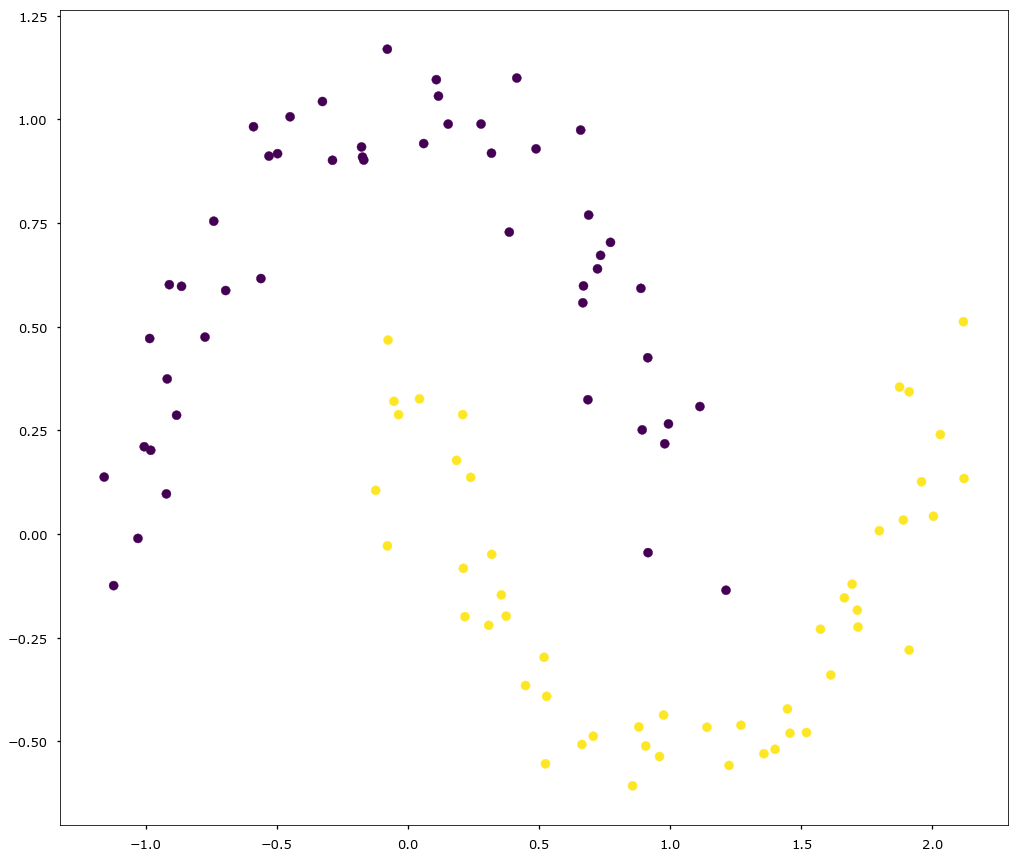

In [21]:
X, y = make_moons(noise=0.1)
plt.figure(figsize=(17,15))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [22]:
interact(ada_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), Output()), _dom_classes=('widge…

<function __main__.ada_demo>

# Gradient boosting

## Motivation

* Problem: For general loss function $L$ FSAM cannot be solved explicitly
* Analogy with function minimization: when we can't find optimum explicitly we use numerical methods
* Gradient boosting: numerical method for iterative loss minimization


## Gradient descent algorithm

$$
F(w)\to\min_{w},\quad w\in\mathbb{R}^{N}
$$

Gradient descend algorithm:

**Input**: $\eta$-parameter, controlling the speed of convergence $M$-number of iterations

**ALGORITHM**:
* initialize $w$
* for $m=1,2,...M$:
    * $\Delta w = \frac{\partial F(w)}{\partial w}$
	* $w = w-\eta \Delta w$

## Gradient boosting

* Now consider $F\left(f(x_{1}),...f(x_{N})\right)=\sum_{n=1}^{N}\mathcal{L}\left(f(x_{n}),y_{n}\right)$
* Gradient descent performs pointwise optimization, but we need generalization, so we optimize in space of functions.
* Gradient boosting implements modified gradient descent in function space:
    * find $z_{i}=-\frac{\partial\mathcal{L}(r,y_{i})}{\partial r}|_{r=f^{m-1}(x_{i})}$
    * fit base learner $h_{m}(x)$ to $\left\{ (x_{i},z_{i})\right\} _{i=1}^{N}$


<center><img src='img/golf-MSE.png' width=900></center>

<center><img src='img/golf-table.svg' width=900></center>

Source - http://explained.ai/gradient-boosting/index.html

In [10]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

In [11]:
def grad_small_demo(n_est=0, max_depth=1, learning_rate=0.1, show_base_pred=False):
    
    fig, ax = plt.subplots(2,1, figsize=(16,19))
    

    y = np.array([100, 250, 140, 220])
    X = np.array([[10, 21, 7, 18]]).T

    x_range = np.linspace(6, 22, 100).reshape((-1,1))

    if n_est:
        model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=50, 
                                          max_depth=max_depth, random_state=123)
        model.fit(X, y)
        dt = model.estimators_[n_est-1][0]
        if show_base_pred:
            if n_est == 1:
                y_hat = np.ones(100)*np.mean(y)
            else:
                y_hat = list(model.staged_predict(x_range))[n_est-2]
            y_hat_base = dt.predict(x_range) * learning_rate + y_hat
        else:
            y_hat = list(model.staged_predict(x_range))[n_est-1]

    else:
        y_hat = np.ones_like(x_range)*np.mean(y)
        y_hat_base = np.ones_like(x_range)*y_hat

    ax[0].scatter(X, y)
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$y$')


    if show_base_pred:
        ax[0].plot(x_range, y_hat, linestyle='-', c='r', label='previous prediction')
        ax[0].plot(x_range, y_hat_base, linestyle=':', c='g', label='final prediction')
    else:
        ax[0].plot(x_range, y_hat, linestyle='-', c='r', label='prediction')

    ax[0].legend()

    if n_est:
        with open('./tree.dot', 'w') as fout:
            export_graphviz(dt, out_file=fout, feature_names=['x'], 
                           filled=True, rounded=True,  special_characters=True)
        command = ["dot", "-Tpng", "./tree.dot", "-o", "./tree.png"]
        subprocess.check_call(command)
        ax[1].imshow(plt.imread('tree.png'))

In [12]:
interact(grad_small_demo,
         n_est=IntSlider(min=0, max=50, value=0, step=1), 
         learning_rate=FloatSlider(min=0.1, max=1., value=0.1, step=0.05),
         max_depth=IntSlider(min=1, max=5, value=1, step=1))

interactive(children=(IntSlider(value=0, description='n_est', max=50), IntSlider(value=1, description='max_dep…

<function __main__.grad_small_demo>

## Gradient boosting

**Input**: training dataset $(x_{i},y_{i}),\,i=1,2,...N$; loss function $\mathcal{L}(f,y)$; learning rate $\nu$ and the number $M$ of successive additive approximations.

1. Fit initial approximation $f_{0}(x)$ (might be taken $f_{0}(x)\equiv0$)
2. For each step $m=1,2,...M$:

    1. calculate derivatives $z_{i}=-\frac{\partial\mathcal{L}(r,y_{i})}{\partial r}|_{r=f^{m-1}(x_{i})}$
    2. fit $h_{m}$ to $\{(x_{i},z_{i})\}_{i=1}^{N}$, for example by solving
$$
\sum_{n=1}^{N}(h_{m}(x_{n})-z_{n})^{2}\to\min_{h_{m}}
$$
    4. set $f_{m}(x)=f_{m-1}(x)+\nu h_{m}(x)$


**Output**: approximation function $f_{M}(x)=f_{0}(x)+\sum_{m=1}^{M}\nu h_{m}(x)$

* What changes with classification?

* Nothing!

<center><img src='https://gif.cmtt.space/0/comment-media/comment-14190/d5ccd05658.jpg'></center>

In [13]:
from IPython.display import display

def logloss(y, p):
    y = np.c_[1-y, y]
    if len(p.shape) != 2:
        p = np.c_[1-p, p]
    return (-y*np.log(p)).sum(axis=1)

def grad(y, p):
    if len(p.shape) == 2:
        p = p[:,1]
    return(y-p)/(p*(1-p))

def sigmoid(score):
    return 1./(1 + np.exp(-score))

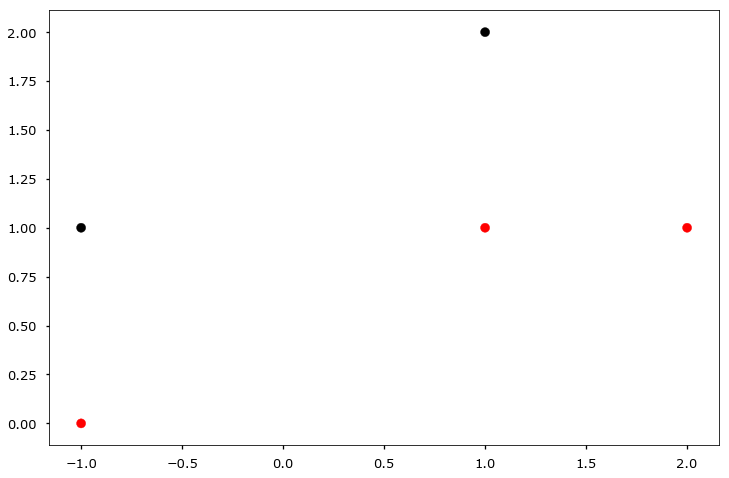

In [14]:
y = np.array([0, 0, 1, 1, 0])
X = np.array([
    [1,1],
    [2,1],
    [1,2],
    [-1,1],
    [-1,0],
])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='flag')

In [15]:
def grad_small_demo_class(n_est=0, max_depth=1, learning_rate=0.1):

    fig, ax = plt.subplots(2,1, figsize=(16,19))

    y = np.array([0, 0, 1, 1, 0])
    X = np.array([
        [1,1],
        [2,1],
        [1,2],
        [-1,1],
        [-1,0],
    ])


    xx1, xx2 = np.meshgrid(np.arange(X[:,0].min()-1, X[:,0].max()+1, 0.01),
                           np.arange(X[:,1].min()-1, X[:,1].max()+1, 0.01))

    XX = np.c_[xx1.ravel(), xx2.ravel()]

    if n_est:
        model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_est, 
                                           max_depth=max_depth, random_state=123)
        model.fit(X, y)
        dt = model.estimators_[n_est-1][0]

        y_hat_score = list(model.staged_decision_function(X))[-1].flatten()

        if n_est >= 2:    
            y_hat_prev_score = list(model.staged_decision_function(X))[-2].flatten()

        else:
            y_hat_prev_score = np.ones_like(y)*(-np.log(1./np.mean(y) - 1))
    else:
        y_hat_score = -np.log(1./np.mean(y) - 1)
        y_hat_prev_score = np.ones_like(y)*np.nan

    y_hat = sigmoid(y_hat_score)
    y_hat_prev = sigmoid(y_hat_prev_score)

    loss = logloss(y, y_hat_prev)
    gradient = grad(y, y_hat_prev)

    df = pd.DataFrame(data={'class': y, 
                            'score_stage_{}'.format(n_est-1): y_hat_prev_score, 
                            'prediction_stage_{}'.format(n_est-1): y_hat_prev, 
                            'logloss': loss, 
                            'gradient': gradient,
                            'score_stage_{}'.format(n_est): y_hat_score, 
                            'prediction_stage_{}'.format(n_est): y_hat })

    display(df)

    ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap='flag')
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')


    if n_est:
        y_hat_all = model.predict_proba(XX)[:, 1]
        y_hat_all = y_hat_all.reshape(xx1.shape)
    else:
        y_hat_all = np.ones_like(xx1)*np.mean(y)

    ax[0].set_title('iteration = %d' % n_est )
    ax[0].contourf(xx1, xx2, y_hat_all, cmap=plt.cm.Paired, alpha=0.1)


    if n_est:
        with open('./tree.dot', 'w') as fout:
            export_graphviz(dt, out_file=fout, feature_names=['x_1', 'x_2'], 
                           filled=True, rounded=True,  special_characters=True)
        command = ["dot", "-Tpng", "./tree.dot", "-o", "./tree.png"]
        subprocess.check_call(command)
        ax[1].imshow(plt.imread('tree.png'))

In [16]:
interact(grad_small_demo_class,
         n_est=IntSlider(min=1, max=50, value=1, step=1), 
         learning_rate=FloatSlider(min=0.1, max=1., value=0.1, step=0.05),
         max_depth=IntSlider(min=1, max=5, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=50, min=1), IntSlider(value=1, description='…

<function __main__.grad_small_demo_class>

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

def grad_demo(n_est=1):
    
    np.random.seed(123)
    X = np.random.uniform(-10, 10, 500)

    y = np.sin(X)/X + np.random.normal(0, .1, 500)
    plt.scatter(X, y)
    

    gbr = GradientBoostingRegressor(n_estimators=n_est, learning_rate=0.15)
    gbr_full = GradientBoostingRegressor(n_estimators=200, learning_rate=0.15)
    gbr.fit(X.reshape(-1,1), y)
    gbr_full.fit(X.reshape(-1,1), y)
    
    x_range = np.linspace(X.min(), X.max(), 100).reshape((-1,1))

    for y_hat in gbr.staged_predict(x_range):
        plt.plot(x_range, y_hat, alpha=0.4, c='g')

    y_hat = gbr_full.predict(x_range)
    
    plt.title('Estimators %d' % n_est)
    plt.plot(x_range, y_hat, c='r')
    plt.ylim((-0.5, 1.3))
    plt.xlim(-11,11)
    
    plt.show()

In [18]:
interact(grad_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), Output()), _dom_classes=('widge…

<function __main__.grad_demo>

## Modified gradient descent algorithm

**Input**: $M$-number of iterations

**ALGORITHM**:
* initialize $w$
* for $m=1,2,...M$:
    * $\Delta w = \frac{\partial F(w)}{\partial w}$
    * $c^* = \arg\min_c F(w-c \Delta w)$
    * $w = w-c^* \Delta w$

## Gradient boosting with optimal coefficient

**Input**: training dataset $(x_{i},y_{i}),\,i=1,2,...N$; loss function $\mathcal{L}(f,y)$; learning rate $\nu$ and the number $M$ of successive additive approximations.

1. Fit initial approximation $f_{0}(x)$ (might be taken $f_{0}(x)\equiv0$)
2. For each step $m=1,2,...M$:

    1. calculate derivatives $z_{i}=-\frac{\partial\mathcal{L}(r,y_{i})}{\partial r}|_{r=f^{m-1}(x_{i})}$
    2. fit $h_{m}$ to $\{(x_{i},z_{i})\}_{i=1}^{N}$, for example by solving
$$
\sum_{n=1}^{N}(h_{m}(x_{n})-z_{n})^{2}\to\min_{h_{m}}
$$
3. solve univariate optimization problem:
$$
\sum_{i=1}^{N}\mathcal{L}\left(f_{m-1}(x_{i})+c_{m}h_{m}(x_{i}),y_{i}\right)\to\min_{c_{m}\in\mathbb{R}_{+}}
$$

4. set $f_{m}(x)=f_{m-1}(x)+c_m h_{m}(x)$


**Output**: approximation function $f_{M}(x)=f_{0}(x)+\sum_{m=1}^{M}c_m h_{m}(x)$

## Gradient boosting of trees

**Input** : training dataset $(x_{i},y_{i}),\,i=1,2,...N$; loss function $\mathcal{L}(f,y)$ and the number $M$ of successive additive approximations.

1. Fit constant initial approximation $f_{0}(x)$: $f_{0}(x)=\arg\min_{\gamma}\sum_{i=1}^{N}\mathcal{L}(\gamma,\,y_{i})$
2. For each step $m=1,2,...M$:
    1. calculate derivatives $z_{i}=-\frac{\partial\mathcal{L}(r,y)}{\partial r}|_{r=f^{m-1}(x)}$
    2. fit regression tree $h^{m}$ on $\{(x_{i},z_{i})\}_{i=1}^{N}$ with some loss function, get leaf regions $\{R_{j}^{m}\}_{j=1}^{J_{m}}$.
    3. for each terminal region $R_{j}^{m}$, $j=1,2,...J_{m}$ solve univariate optimization problem:
$$
\gamma_{j}^{m}=\arg\min_{\gamma}\sum_{x_{i}\in R_{j}^{m}}\mathcal{L}(f_{m-1}(x_{i})+\gamma,\,y_{i})
$$
    4. update $f_{m}(x)=f_{m-1}(x)+\sum_{j=1}^{J_{m}}\gamma_{j}^{m}\mathbb{I}[x\in R_{j}^{m}]$

**Output**: approximation function $f_{M}(x)$

## Modification of boosting for trees

* Compared to first method of gradient boosting, boosting of regression trees finds additive coefficients individually for each terminal region $R_{j}^{m}$, not globally for the whole classifier $h^{m}(x)$.
* This is done to increase accuracy: forward stagewise algorithm cannot be applied to find $R_{j}^{m}$, but it can be applied to find $\gamma_{j}^{m}$, because second task is solvable for arbitrary $L$.
* Max leaves $J$
    * interaction between no more than $J-1$ terms
* $M$ controls underfitting-overfitting tradeoff and selected using validation set


## Shrinkage & subsampling

* Shrinkage of general GB, step (d):
$$
f_{m}(x)=f_{m-1}(x)+\nu c_{m}h_{m}(x)
$$
* Shrinkage of trees GB, step (d):

$$
f_{m}(x)=f_{m-1}(x)+\nu\sum_{j=1}^{J_{m}}\gamma_{jm}\mathbb{I}[x\in R_{jm}]
$$

* Comments:
    * $\nu\in(0,1]$
    * $\nu \text{ decreases } \implies M \text{ increases } $

* Subsampling
    * increases speed of fitting
    * may increase accuracy


## Interpretation - partial dependency plots

* Problem - we have huge black-box model $\hat{y}^k = F(x^k_1, x^k_2,\dots,x^k_p)$
* Want to have at least some interpretation
* Idea - cosider a single predictor $x_j$
    * Find out its influence on prediction after we have "averaged out" the influence of all other variables:
    
$$ \phi_j(x) = \frac{1}{N}\sum_{k=1}^N F(x^k_1, x^k_2,\dots, x^k_{j-1}, x, x^k_{j+1} \dots,x^k_p) $$

<center><img src='img/partial_dep.png' width=1000></center>

* [Gradient Boosting PlayGround](http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)
* [LightGBM](https://github.com/Microsoft/LightGBM), [XGBoost](https://github.com/dmlc/xgboost), [CatBoost](https://github.com/catboost/catboost)
* [Libs overview](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)
* [Gradient boosting by Alexander Dyakonov](https://alexanderdyakonov.wordpress.com/2017/06/09/%d0%b3%d1%80%d0%b0%d0%b4%d0%b8%d0%b5%d0%bd%d1%82%d0%bd%d1%8b%d0%b9-%d0%b1%d1%83%d1%81%d1%82%d0%b8%d0%bd%d0%b3/)
* [XGBoost video tutorial](http://education.parrotprediction.teachable.com/p/practical-xgboost-in-python)
* [GBM tutorial](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/)